# UJ Deep Neural Networks - project_1 - ResNet implementation

### Imports

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from collections import OrderedDict

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

### Load CIFAR10 dataset

In [2]:
def dataset_loader(datset_path, batch_size):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
  ])

  train_dataset = datasets.CIFAR10(root=datset_path, train=True, download=True, transform=transform)
  test_dataset = datasets.CIFAR10(root=datset_path, train=False, download=True, transform=transform)

  train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))

  print(f"Dataset random image shape: {train_dataset[0][0].numpy().shape}")

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

  return train_loader, val_loader, test_loader

### Residual block implementation

In [3]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()

    self.layers = nn.Sequential(OrderedDict([
        ('conv1', nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)),
        ('bn1', nn.BatchNorm2d(out_channels)),
        ('relu1', nn.ReLU()),
        ('conv2', nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)),
        ('bn2', nn.BatchNorm2d(out_channels)),
        ('relu2', nn.ReLU()),
        ('conv3', nn.Conv2d(
            out_channels,
            out_channels * 4,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)),
        ('bn3', nn.BatchNorm2d(out_channels * 4))
    ]))

    self.skip_connection = nn.Sequential()

    if stride != 1 or in_channels != out_channels * 4:
      self.skip_connection = nn.Sequential(OrderedDict([
          ('sc_conv1', nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, padding=0, bias=False)),
          ('sc_bn1', nn.BatchNorm2d(out_channels * 4))
      ]))

  def forward(self, x):
    out = self.layers(x)
    out += self.skip_connection(x)
    out = F.relu(out)
    return out

### ResNet class implementation

In [4]:
class ResNet(nn.Module):
  def __init__(self, num_of_blocks, num_of_classes):
    super(ResNet, self).__init__()

    self.in_channels = 64

    self.starting_layers = nn.Sequential(OrderedDict([
        ('conv0', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)),
        ('bn0', nn.BatchNorm2d(64)),
        ('relu0', nn.ReLU()),
        ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    ]))

    self.block1 = self.make_block(64, num_of_blocks[0], stride=1)
    self.block2 = self.make_block(128, num_of_blocks[1], stride=2)
    self.block3 = self.make_block(256, num_of_blocks[2], stride=2)
    self.block4 = self.make_block(512, num_of_blocks[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * 4, num_of_classes)

  def make_block(self, out_channels, num_of_blocks, stride):
    strides = []
    strides.append(stride)
    for i in range(num_of_blocks-1):
      strides.append(1)

    layers = []
    for _stride in strides:
      layers.append(ResidualBlock(self.in_channels, out_channels, stride=_stride))
      self.in_channels = out_channels * 4

    # print('layers_list_for_current_block: ', layers)
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.starting_layers(x)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.fc(out)
    return out

  def ResNet56():
    return ResNet(num_of_blocks=[3,4,6,3], num_of_classes=10)

In [5]:
model = ResNet.ResNet56()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 128, 128), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

### Model training

In [6]:
train_loader, val_loader, test_loader = dataset_loader(datset_path='./dataset', batch_size=128)

Files already downloaded and verified
Files already downloaded and verified
Dataset random image shape: (3, 32, 32)
Train dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
def train_model(num_of_epochs, train_loader, checkpoints_dir):
  train_samples, val_samples = 45000, 5000
  train_summ, val_summ = [], []

  for epoch in range(num_of_epochs):

    # Training
    train_loss = 0
    train_correct = 0
    model.train().cuda()

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted_outputs = torch.max(outputs.data, 1)
      train_correct += (predicted_outputs == labels).float().sum().item()
      train_loss += loss.item()

    train_loss /= train_samples
    train_acc = train_correct / train_samples
    train_summ.append((train_loss, train_acc))

    # Validation
    val_loss = 0
    val_correct = 0
    model.eval().cuda()

    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted_outputs = torch.max(outputs.data, 1)
        val_correct += (predicted_outputs == labels).float().sum().item()
        val_loss += loss.item()

      val_loss /= val_samples
      val_acc = val_correct / val_samples
      val_summ.append((val_loss, val_acc))

    print(f"Epoch: {epoch+1}/{num_of_epochs}: train_loss = {train_loss:.4f} | train_acc = {train_acc:.4f}, val_loss = {val_loss:.4f} | val_acc: {val_acc:.4f}")

    os.makedirs(checkpoints_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoints_dir, f'model_checkpoint_gpu_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)

  return train_summ, val_summ

In [9]:
train_summ, val_summ = train_model(num_of_epochs=150, train_loader=train_loader, checkpoints_dir='./training_checkpoints')

Epoch: 1/150: train_loss = 0.0197 | train_acc = 0.2508, val_loss = 0.0149 | val_acc: 0.3694
Epoch: 2/150: train_loss = 0.0121 | train_acc = 0.4368, val_loss = 0.0110 | val_acc: 0.4988
Epoch: 3/150: train_loss = 0.0103 | train_acc = 0.5228, val_loss = 0.0103 | val_acc: 0.5550
Epoch: 4/150: train_loss = 0.0091 | train_acc = 0.5806, val_loss = 0.0089 | val_acc: 0.6184
Epoch: 5/150: train_loss = 0.0081 | train_acc = 0.6290, val_loss = 0.0193 | val_acc: 0.6302
Epoch: 6/150: train_loss = 0.0073 | train_acc = 0.6699, val_loss = 0.0080 | val_acc: 0.6476
Epoch: 7/150: train_loss = 0.0066 | train_acc = 0.7042, val_loss = 0.0075 | val_acc: 0.6764
Epoch: 8/150: train_loss = 0.0058 | train_acc = 0.7375, val_loss = 0.0073 | val_acc: 0.6960
Epoch: 9/150: train_loss = 0.0053 | train_acc = 0.7650, val_loss = 0.0065 | val_acc: 0.7160
Epoch: 10/150: train_loss = 0.0049 | train_acc = 0.7852, val_loss = 0.0064 | val_acc: 0.7296
Epoch: 11/150: train_loss = 0.0042 | train_acc = 0.8127, val_loss = 0.0063 | va

### Generate Plots

In [10]:
def generate_plots(train_summ, val_summ):
  train_loss, train_acc = zip(*train_summ)
  val_loss, val_acc = zip(*val_summ)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Train Loss', marker='o')
  plt.plot(val_loss, label='Validation Loss', marker='o')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label='Train Accuracy', marker='o')
  plt.plot(val_acc, label='Validation Accuracy', marker='o')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

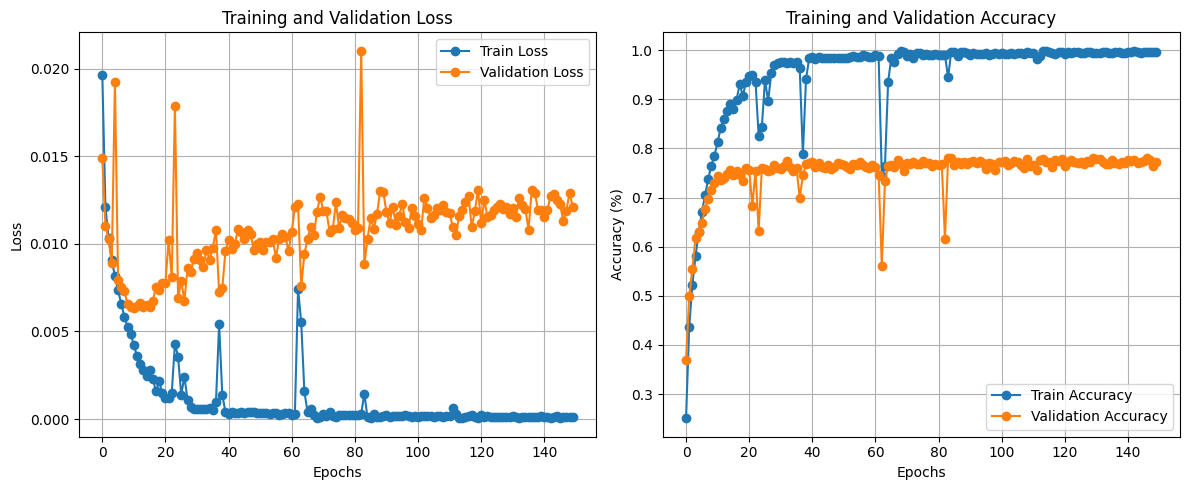

In [11]:
generate_plots(train_summ, val_summ)

### Model testing

In [12]:
test_samples = 10000
test_correct = 0

model.eval().cuda()

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    _, predicted_outputs = torch.max(outputs.data, 1)
    test_correct += (predicted_outputs == labels).float().sum().item()

test_acc = test_correct / test_samples
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7634
